In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(f"We are training on {device} for this experiment")

assert 'cuda' in repr(device), "GPU is not selected in hardware accelerator dropdown"

We are training on cuda:0 for this experiment


In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

batch_size = 128

#Get dataset class object corresponding to train split
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

#Create data loader from train dataset object
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

#Get dataset class object corresponding to test split
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

#Create data loader from test dataset object
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



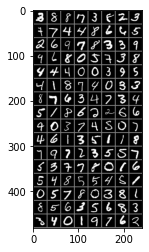

3     8     8     7     3     8     2     3     7     7     4     4     8     6     6     5     2     6     9     7     8     3     3     9     9     6     8     0     5     7     3     8     4     4     4     0     0     3     9     5     4     1     8     7     4     0     3     3     8     7     6     3     4     7     3     4     5     1     8     6     2     2     6     6     4     0     3     7     4     5     0     7     4     6     1     3     5     1     1     8     7     9     7     2     3     5     5     7     5     3     7     7     8     0     1     6     5     4     8     5     5     4     5     1     0     5     7     8     0     3     8     1     8     5     6     3     5     6     8     3     3     4     0     1     9     7     6     2    


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [5]:
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv1resi = nn.Conv2d(128, 128, 1) # this is called a residual network

        self.conv3 = nn.Conv2d(128, 128, 3, 1, 1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, 3, 1, 1)
        self.bn4 = nn.BatchNorm2d(128)

        self.conv2resi = nn.Conv2d(128, 512, 1)

        self.conv5 = nn.Conv2d(128, 256, 3, 1, 1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 512, 3, 1, 1)
        self.bn6 = nn.BatchNorm2d(512)

        self.conv3resi = nn.Conv2d(512, 512, 1)

        self.conv7 = nn.Conv2d(512, 512, 3, 1, 1)
        self.bn7 = nn.BatchNorm2d(512)
        self.conv8 = nn.Conv2d(512, 512, 3, 1, 1)
        self.bn8 = nn.BatchNorm2d(512)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, 10)

    def forward(self, x):
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        a = x
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.bn4(F.relu(self.conv4(x))) + self.conv1resi(a)
        b = x
        x = self.bn5(F.relu(self.conv5(x)))
        x = self.bn6(F.relu(self.conv6(x))) + self.conv2resi(b)
        c = x
        x = self.bn7(F.relu(self.conv7(x)))
        x = self.bn8(F.relu(self.conv8(x))) + self.conv3resi(c)
        x = torch.flatten(self.avgpool(x), 1)
        x = self.fc(x)
        return x


net = Net().to(device)
# print(net)

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD([param for param in net.parameters() if param.requires_grad==True], lr=0.001, momentum=0.9)
# don't optimse only those which needs to update don't pass all the parameters 

In [7]:
def validator(testloader=None,net=None):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            # perform max along dimension 1, since dimension 0 is batch dimension
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the test images: {100 * correct // total} %')
    return correct/total


In [8]:
start_epoch=0
end_epoch=1

#If you are resuming your model, Uncomment following lines

#checkpoint = torch.load(your_google_drive_path+'checkpoint.pth')
#start_epoch = checkpoint['epoch']+1
#net.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [9]:
from google.colab import drive
drive.mount('/content/drive')
your_google_drive_path = "/content/drive/MyDrive/checkpoints/"
import os
assert os.path.isdir(your_google_drive_path), f"{your_google_drive_path} is not a valid location"

Mounted at /content/drive


In [10]:
best_accuracy = -1.0
for epoch in range(start_epoch,end_epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
    
    current_accuracy = validator(testloader=testloader,net=net)
    if current_accuracy>best_accuracy:
        best_accuracy = current_accuracy
        
        torch.save(
            {'epoch':epoch, 
             'model_state_dict': net.state_dict(), 
             'optimizer_state_dict': optimizer.state_dict()
             }, 
             
             your_google_drive_path+'best_model.pth')
    
    #Save model as checkpoint
    torch.save(
        {'epoch':epoch, 
         'model_state_dict': net.state_dict(), 
         'optimizer_state_dict': optimizer.state_dict() 
         }, 
         your_google_drive_path+'checkpoint.pth')



print('Finished Training')

Accuracy of the network on the test images: 96 %
Finished Training


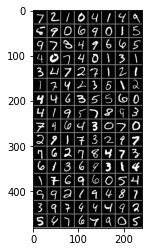

GroundTruth:  7     2     1     0    


In [11]:
dataiter = iter(testloader)
images, labels = next(dataiter)
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [12]:
net_best = Net().to(device)
checkpoint = torch.load(your_google_drive_path+'best_model.pth')
net_best.load_state_dict(checkpoint['model_state_dict'])

images = images.to(device)
labels = labels.to(device)

outputs = net_best(images)

In [13]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  7     2     1     0    


**OPTIONAL: TASK 2**

In [90]:
def validator_classwise(testloader=None,net=None, classes=None):
    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    # again no gradients needed
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1


    # print accuracy for each class

    total_accuracy = 0
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        total_accuracy += accuracy
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
    # print(len(total_pred.items()))
    
    return total_accuracy / len(total_pred.items())
def validator(testloader=None,net=None):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            # calculate outputs by running images through the network
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()*2.5
    # the class with the highest energy is what we choose as prediction
    # perform max along dimension 1, since dimension 0 is batch dimension 
    print(f'Accuracy of the network on the test images: {100*correct // total} %')
    return correct/total
#Test your logic by uncommenting following line
validator_classwise(testloader=testloader,net=net_best, classes=classes)


**OPTIONAL: TASK 3**

In [15]:
batch_size = 256 

**TRANSFER LEARNING**

In [70]:
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os

In [75]:
batch_size = 10
from google.colab import drive 
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [76]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os


mean=0.5
std=0.5
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((28,28)),
        transforms.ToTensor(),
        transforms.Normalize(mean,std)
    ]),
    'val': transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((28,28)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

data_dir = '/content/drive/MyDrive/my_mnist/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train','val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train','val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


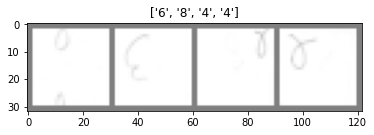

In [81]:
# show images
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [91]:
for param in net.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 10)
net = net.to(device)
criterion = nn.CrossEntropyLoss()

start_epoch=0
end_epoch=25

best_accuracy = -1.0
for epoch in range(start_epoch,end_epoch):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(dataloaders['train'], 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 45 == 44:    # print every 45 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 45:.3f}')
            running_loss = 0.0
    
    current_accuracy = validator(testloader=dataloaders['val'],net=net)
    if current_accuracy>best_accuracy:
        best_accuracy = current_accuracy
    


[1,    45] loss: 2.317
[1,    90] loss: 2.308
[1,   135] loss: 2.311
[1,   180] loss: 2.302
[1,   225] loss: 2.304
Accuracy of the network on the test images: 20.0 %
[2,    45] loss: 2.312
[2,    90] loss: 2.307
[2,   135] loss: 2.308
[2,   180] loss: 2.306
[2,   225] loss: 2.308
Accuracy of the network on the test images: 17.0 %
[3,    45] loss: 2.303
[3,    90] loss: 2.311
[3,   135] loss: 2.303
[3,   180] loss: 2.309
[3,   225] loss: 2.304
Accuracy of the network on the test images: 17.0 %
[4,    45] loss: 2.306
[4,    90] loss: 2.313
[4,   135] loss: 2.305
[4,   180] loss: 2.304
[4,   225] loss: 2.312
Accuracy of the network on the test images: 27.0 %
[5,    45] loss: 2.311
[5,    90] loss: 2.303
[5,   135] loss: 2.311
[5,   180] loss: 2.306
[5,   225] loss: 2.305
Accuracy of the network on the test images: 17.0 %
[6,    45] loss: 2.311
[6,    90] loss: 2.304
[6,   135] loss: 2.306
[6,   180] loss: 2.303
[6,   225] loss: 2.309
Accuracy of the network on the test images: 20.0 %
[7, 